# Learning Rules; SGD, WP, and NP
In this notebook we will explore the efficacy of Stochastic Gradient Descent (SGD), Weight Perturbation (WP), and Node Perturbation (NP) in order to learn weights to two different neural network tasks:

1. Learn from a noisy teacher, and
2. Classify MNIST digits.

Note WP and NP use perturbation-type methods, i.e. they involve learning from a global error signal, which has been seen in the scientific community as biologically more plausible.

In [1]:
# Imports
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

# Global Parameters (NN architecture)

Lx = 10 # Inputs
Lh = 100 # Hidden layer Neurons
Ly = 10 # Outputs

def relu(x):
  return np.maximum(0,x)

def step(x):
  return np.heaviside(x, np.zeros(x.shape))


## Stochastic Gradient Descent (PyTorch)

In [2]:
import torch
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

In [3]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(Lx, Lh) 
        self.fc2 = nn.Linear(Lh, Ly)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net_ts = Net()

In [4]:
wh_son = torch.normal(torch.zeros(Lh,Lx), torch.ones(Lh,Lx))
wh_dad = torch.normal(torch.zeros(Lh,Lx), torch.ones(Lh,Lx))

wy_son = torch.normal(torch.zeros(Ly,Lh), torch.ones(Ly,Lh))
wy_dad = torch.normal(torch.zeros(Ly,Lh), torch.ones(Ly,Lh))


## The idea is we want the son to converge to the dad.
N = 512
x = torch.normal(torch.zeros(N, Lx), torch.ones(N, Lx))

zeta = torch.normal(torch.zeros(N,Ly), 0.01*torch.ones(N,Ly))
target = (wy_dad @ F.relu(wh_dad @ x.T)).T + zeta

optimizer = optim.SGD(net_ts.parameters(), lr=0.001)
epochs = torch.arange(1e4)
criterion = nn.MSELoss()

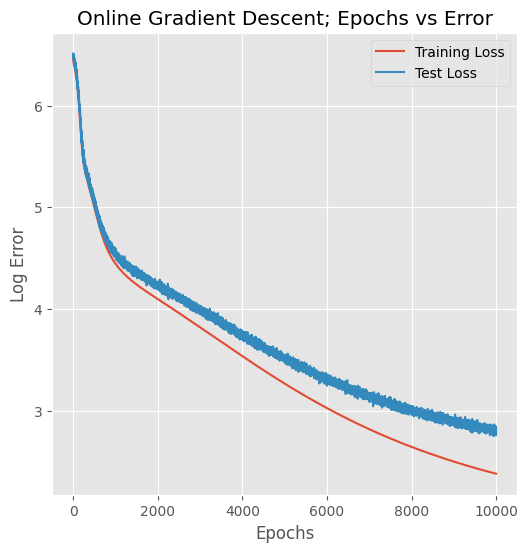

In [5]:
errors = []
test_errors = []

for epoch in epochs:
  
  optimizer.zero_grad()   # zero the gradient buffers
  output = net_ts(x)
  loss = criterion(output, target)
  loss.backward()
  optimizer.step()  

  with torch.no_grad():
    test_N = 1000
    x_test = torch.normal(torch.zeros(test_N, Lx), torch.ones(test_N, Lx))
    zeta = torch.normal(torch.zeros(test_N,Ly), 0.01*torch.ones(test_N,Ly))
    test_target = (wy_dad @ F.relu(wh_dad @ x_test.T)).T + zeta
    test_output = net_ts(x_test)
    test_loss = criterion(test_output, test_target)
    test_errors.append(float(torch.log(test_loss)))

  errors.append(float(torch.log(loss)))

plt.figure(figsize = (6,6))
plt.plot(epochs, errors, label = "Training Loss")
plt.plot(epochs, test_errors, label = "Test Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Log Error")
plt.title("Online Gradient Descent; Epochs vs Error")
plt.savefig("sgd_ts.png")

## Node Perturbation

In [6]:

def update_node_pert(weights, x, target, eta,sigma, loss_fn):
  final_son, hidden_son = weights

  # Forward 
  x_h = relu(x @ hidden_son.T)
  y_son = x_h @ final_son.T

  #error = np.linalg.norm(y_hat_dad - y_son)
  error = loss_fn(target, y_son)

  # Forward with perturbations

  xi_h = np.random.normal(scale = sigma, size = (Lh))

  xi_y = np.random.normal(scale = sigma, size = (Ly))

  x_h_xi = relu(x @ hidden_son.T) + xi_h

  y_son_xi = ( x_h_xi @ final_son.T) + xi_y

  #error_xi = np.linalg.norm(target - y_son_xi
  error_xi = loss_fn(target, y_son_xi)

  total_err = (eta/sigma) * (error_xi - error)
  #np.einsum("i,jk->ik", xi_h, x)
  update_h =  total_err * np.einsum("i,jk->ik", xi_h, x)
  update_y =  total_err * np.einsum("i,jk->ik", xi_y, x_h)

  return update_h, update_y, error


epochs = np.arange(1e4)

wh_son = np.random.normal(size = (Lh,Lx))
wh_dad = np.random.normal(size = (Lh,Lx))

wy_son = np.random.normal(size = (Ly,Lh))
wy_dad = np.random.normal(size = (Ly,Lh))

## The idea is we want the son to converge to the dad.



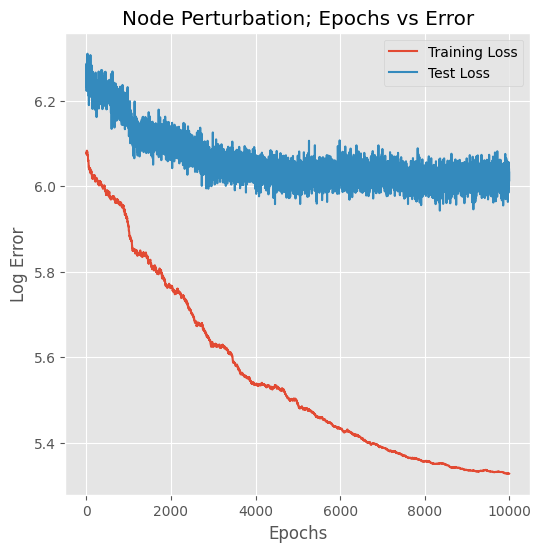

In [7]:
# Node Perturbation

errors = []
test_errors = []
testing = True

N = 512
x = np.random.normal(size = (N, Lx)) # In transposed form for
target = relu(relu(x @ wh_dad.T) @ wy_dad.T)

loss_fn = lambda A,B: np.mean(0.5*(A-B)**2)

for epoch in epochs:
  eta = 0.01

  hidden_update, final_update, err = update_node_pert((wy_son, wh_son), x, target, eta, sigma = 1/(N * Lh * Ly), loss_fn=loss_fn)
  # update_online(w,x, 1/(13+N))

  wh_son -= hidden_update
  wy_son -= final_update
  
  if testing:
    test_N = 1024
    x_test = np.random.normal(np.zeros((test_N, Lx)), np.ones((test_N, Lx)))

    test_target = (wy_dad @ relu(wh_dad @ x_test.T)).T
    test_output = (wy_son @ relu(wh_son @ x_test.T)).T
    test_loss = loss_fn(test_output, test_target)
    test_errors.append(float(np.log(test_loss)))

  errors.append(np.log(err))

plt.figure(figsize = (6,6))
plt.plot(epochs, errors, label = "Training Loss")
if testing:
    plt.plot(epochs, test_errors, label = "Test Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Log Error")
plt.title("Node Perturbation; Epochs vs Error")
plt.savefig("np_ts")

## Weight Perturbation

In [8]:
# Weight Perturbation

def update_weight_pert(weights, x, target, eta,sigma, loss_fn):
  final_son, hidden_son = weights
  
  # Forward 
  x_h = relu(x @ hidden_son.T)
  y_son = x_h @ final_son.T

  #error = np.linalg.norm(y_hat_dad - y_son)
  error = loss_fn(target, y_son)

  # Forward with perturbations

  xi_h = np.random.normal(scale = sigma, size = (Lh, Lx))

  xi_y = np.random.normal(scale = sigma, size = (Ly, Lh))

  x_h_xi = relu(x @ (hidden_son + xi_h).T)
  y_son_xi = x_h_xi @ (final_son + xi_y).T

  error_xi = loss_fn(target, y_son_xi)

  total_err = (eta/sigma) * (error_xi - error)
  update_h =  total_err * xi_h
  update_y =  total_err * xi_y

  return update_h, update_y, error


epochs = np.arange(1e4)

wh_son = np.random.normal(size = (Lh,Lx))
wh_dad = np.random.normal(size = (Lh,Lx))

wy_son = np.random.normal(size = (Ly,Lh))
wy_dad = np.random.normal(size = (Ly,Lh))

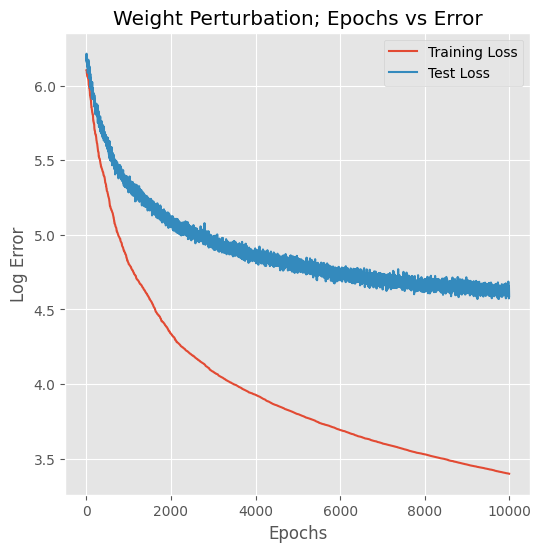

In [9]:
# Weight Perturbation

errors = []
test_errors = []
testing = True


N = 512
x = np.random.normal(size = (N, Lx))
target = relu(relu(x @ wh_dad.T)@ wy_dad.T)

loss_fn = lambda A,B: np.mean(0.5*(A-B)**2)

for epoch in epochs:
  eta = 0.1

  hidden_update, final_update, err = update_weight_pert((wy_son, wh_son), x, target, eta, sigma = 1/(Lh * Ly), loss_fn = loss_fn)

  wh_son -= hidden_update
  wy_son -= final_update
  
  if testing:
    test_N = 1024
    x_test = np.random.normal(np.zeros((test_N,Lx)), np.ones((test_N,Lx)))

    test_target = (wy_dad @ relu(wh_dad @ x_test.T)).T
    test_output = (wy_son @ relu(wh_son @ x_test.T)).T
    test_loss = loss_fn(test_output, test_target)
    test_errors.append(float(np.log(test_loss)))

  errors.append(np.log(err))

plt.figure(figsize = (6,6))
plt.plot(epochs, errors, label = "Training Loss")
if testing:
    plt.plot(epochs, test_errors, label = "Test Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Log Error")
plt.title("Weight Perturbation; Epochs vs Error")
plt.savefig("wp_ts.png")

## Learning MNIST Digit Classification

In [10]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()
N = 1024
train_X = train_X.reshape((train_X.shape[0],28*28))[:N]

train_X = (train_X - train_X.mean())/train_X.std()

test_X = test_X.reshape((test_X.shape[0], 28*28))[:N]
test_X = (test_X - test_X.mean())/test_X.std()

cov_X = train_X.T @ train_X

u, d, v = np.linalg.svd(cov_X)

In [11]:
top_PC = 10

proj_mat = u[:,:10]

proj_X = train_X @ proj_mat
proj_test_X = test_X @ proj_mat

In [12]:
torch_X = torch.from_numpy(proj_X)
torch_test_X = torch.from_numpy(proj_test_X)

torch_Y = torch.from_numpy(train_y[:N]).to(torch.int64)
torch_test_Y = torch.from_numpy(test_y[:N]).to(torch.int64)
y_onehot = F.one_hot(torch_Y)
y_test_onehot = F.one_hot(torch_test_Y)

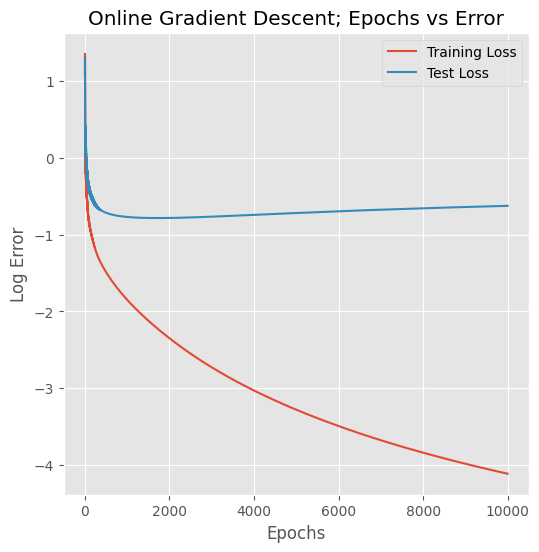

In [13]:

Lx = 10 # Inputs
Lh = 1000 # Hidden layer Neurons
Ly = 10 # Outputs


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(Lx, Lh) 
        self.fc2 = nn.Linear(Lh, Ly)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net().double()
## The idea is we want the son to converge to the dad.

optimizer = optim.SGD(net.parameters(), lr=0.01)
epochs = torch.arange(1e4)
criterion = nn.CrossEntropyLoss()

errors = []
test_errors = []
accuracy_torch = []

for epoch in epochs:
  
  optimizer.zero_grad()   # zero the gradient buffers
  output = net(torch_X)
  loss = criterion(output, torch_Y)
  loss.backward()
  optimizer.step()  
  
  # update_online(w,x, 1/(13+N))
  with torch.no_grad():
    test_output = net(torch_test_X)
    test_loss = criterion(test_output, torch_test_Y)
    test_errors.append(float(torch.log(test_loss)))
    o = torch.argmax(test_output, axis = 1)
    t = torch.argmax(y_test_onehot, axis = 1)
    accuracy_torch.append(100*torch.where(o-t == 0, 1, 0).sum()/N)

  errors.append(float(torch.log(loss)))

plt.figure(figsize = (6,6))
plt.plot(epochs, errors, label = "Training Loss")
plt.plot(epochs, test_errors, label = "Test Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Log Error")
plt.title("Online Gradient Descent; Epochs vs Error")
plt.savefig("sgd_mnist.png")

In [14]:
def softmax(a):
        '''Each row will be converted to a set of probabilities by softmax'''
        a = (a-a.mean())/a.std() # avoid excessive exponents
        return (np.exp(a).T/np.sum(np.exp(a), axis = 1)).T
def cross_entropy_loss(target, value):
    loss = -np.sum(np.multiply(np.log(softmax(value)),  target))
    #print(loss)
    return loss



In [15]:
torch_X = torch.from_numpy(proj_X)

torch_test_X = torch.from_numpy(proj_test_X)

torch_Y = torch.from_numpy(train_y[:N]).to(torch.int64)
torch_test_Y = torch.from_numpy(test_y[:N]).to(torch.int64)

y_onehot = F.one_hot(torch_Y)
y_test_onehot = F.one_hot(torch_test_Y)

wh_son = np.random.normal(size = (Lh,Lx))
wy_son = np.random.normal(size = (Ly,Lh))


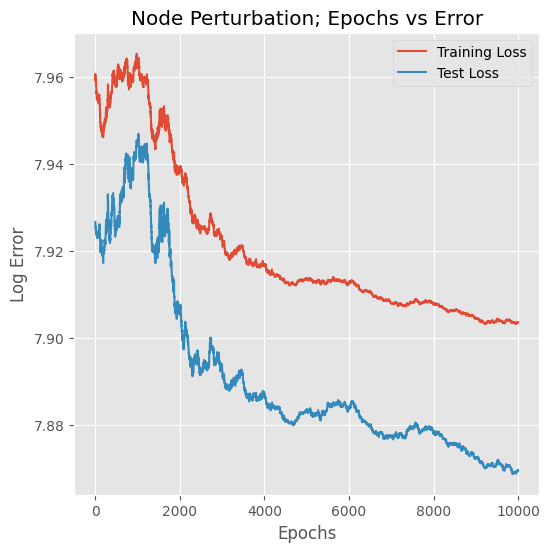

In [16]:
# Node Perturbation

errors = []
test_errors = []
accuracy_np = []
testing = True

x = torch_X.numpy() # In transposed form for
target = y_onehot.numpy()

loss_fn = cross_entropy_loss
epochs = torch.arange(1e4)

x_test = torch_test_X.numpy()
test_target = y_test_onehot.numpy()

for epoch in epochs:
  eta = 1e-4

  hidden_update, final_update, err = update_node_pert((wy_son, wh_son), x, target, eta, sigma = 1/(Lh*Ly), loss_fn=loss_fn)
  wh_son -= hidden_update
  wy_son -= final_update

  wh_son = (wh_son - wh_son.mean())/wh_son.std()
  wy_son = (wy_son - wy_son.mean())/wy_son.std()
  
  if testing:
    test_output = (wy_son @ relu(wh_son @ x_test.T)).T
    test_loss = loss_fn(test_target, test_output)
    test_errors.append(float(np.log(test_loss)))
    o = np.argmax(test_output, axis = 1)
    t = np.argmax(test_target, axis = 1)
    accuracy_np.append(100*np.where(o-t == 0, 1, 0).sum()/N)

  errors.append(np.log(err))

plt.figure(figsize = (6,6))
plt.plot(epochs, errors, label = "Training Loss")
if testing:
    plt.plot(epochs, test_errors, label = "Test Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Log Error")
plt.title("Node Perturbation; Epochs vs Error")
plt.savefig("np_mnist.png")

In [17]:
o = np.argmax(test_output, axis = 1)
t = np.argmax(test_target, axis = 1)
print(f"Accuracy is {100*np.where(o-t == 0, 1, 0).sum()/N:.2f}%")

Accuracy is 5.27%


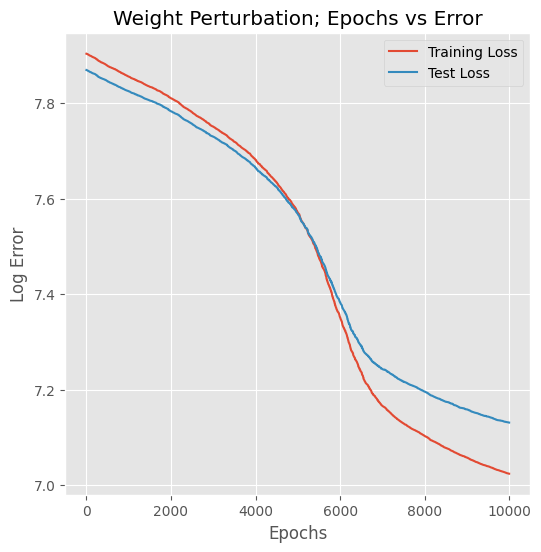

In [18]:
# Weight Perturbation

errors = []
test_errors = []
accuracy_wp = []
testing = True

x = torch_X.numpy() # In transposed form for
target = y_onehot.numpy()

loss_fn = cross_entropy_loss
epochs = torch.arange(1e4)

x_test = torch_test_X.numpy()
test_target = y_test_onehot.numpy()

for epoch in epochs:
  eta = 0.1

  hidden_update, final_update, err = update_weight_pert((wy_son, wh_son), x, target, eta, sigma = 1/(Lh*Ly), loss_fn=loss_fn)
  wh_son -= hidden_update
  wy_son -= final_update

  wh_son = (wh_son - wh_son.mean())/wh_son.std()
  wy_son = (wy_son - wy_son.mean())/wy_son.std()
  
  if testing:
    test_output = (wy_son @ relu(wh_son @ x_test.T)).T
    test_loss = loss_fn(test_target, test_output)
    test_errors.append(float(np.log(test_loss)))
    o = np.argmax(test_output, axis = 1)
    t = np.argmax(test_target, axis = 1)
    accuracy_wp.append(100*np.where(o-t == 0, 1, 0).sum()/N)
    
  errors.append(np.log(err))

plt.figure(figsize = (6,6))
plt.plot(epochs, errors, label = "Training Loss")
if testing:
    plt.plot(epochs, test_errors, label = "Test Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Log Error")
plt.title("Weight Perturbation; Epochs vs Error")
plt.savefig("wp_mnist.png")

In [19]:
o = np.argmax(test_output, axis = 1)
t = np.argmax(test_target, axis = 1)
print(f"Accuracy is {100*np.where(o-t == 0, 1, 0).sum()/N:.2f}%")

Accuracy is 65.43%


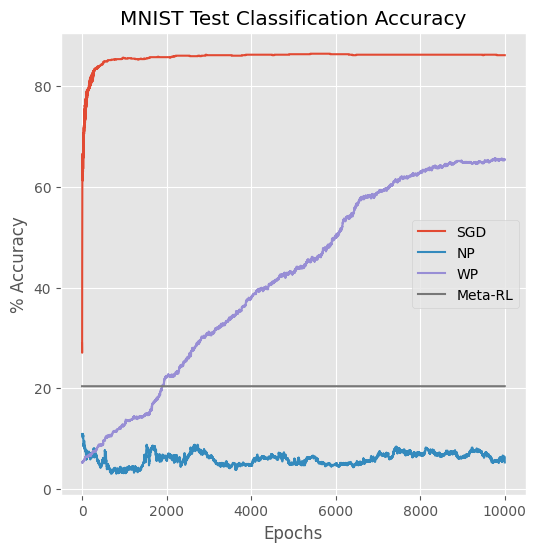

In [24]:
plt.figure(figsize = (6,6))
plt.plot(epochs, accuracy_torch, label = "SGD")
plt.plot(epochs, accuracy_np, label = "NP")
plt.plot(epochs, accuracy_wp, label = "WP")
plt.plot(epochs, [20.4]*epochs.shape[0],label = "Meta-RL")
plt.xlabel("Epochs")
plt.ylabel("% Accuracy")
plt.legend()
plt.title("MNIST Test Classification Accuracy")
plt.savefig("acc.png")